# Simpson's Paradox (Section 4.2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linear_regression import LinearRegression
import algorithms
import postprocessing
import scipy.linalg
import itertools

## Data Generation

In [2]:
np.random.seed(0)

total_observations = 1010
num_observations_pop_1 = 10
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

# Generate X values.
mean_pop_1 = np.array([25])
mean_pop_2 = np.array([0])
vars_pop_1 = np.array([[0.25]])
vars_pop_2 = np.array([[0.25]])

x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)

# Add an intercept term.
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x1 = x[:10]
x2 = x[10:]

x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

# Generate Y values.
epsilon1 = np.random.normal(0, 1, num_observations_pop_1)
slope1 = -1
intercept1 = 40
y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_1[i] + intercept1 + epsilon1[i])

epsilon2 = np.random.normal(0, 1, num_observations_pop_2)
slope2 = -1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_1[i] + intercept2 + epsilon2[i])

y = np.concatenate([y1, y2], axis=0)

## Model Fitting

Fit the data using OLS regression.

In [ ]:
# x_nointercept = x[:,1].reshape(-1,1)
# x2_nointercept = x2[:,1].reshape(-1,1)

In [3]:
lr = LinearRegression(x=x.T, y=y)
lr.fit()
modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}\n"
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 pop B: -0.9895109324018502


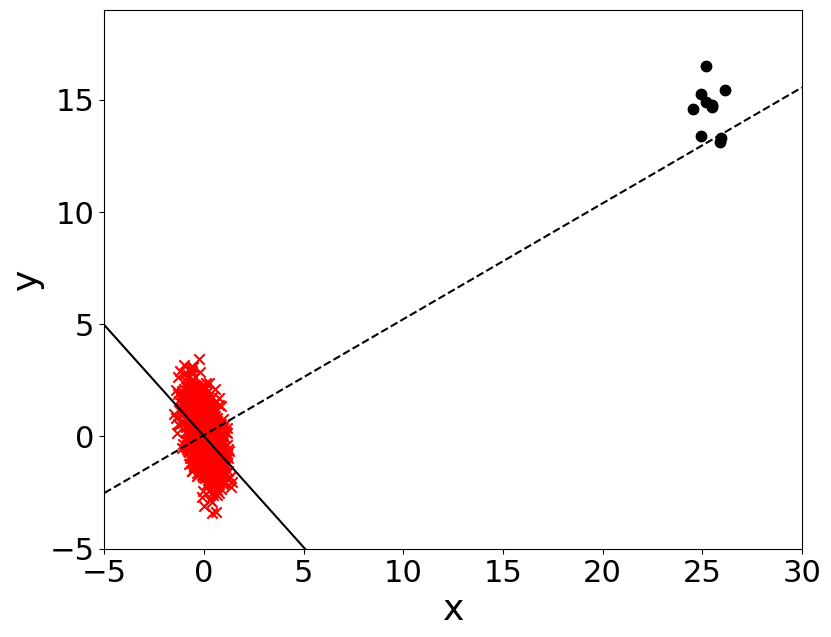

In [4]:
plt.figure(figsize=(9, 7))

plt.scatter(x1[:,1:], y1, marker='o', color='black', label='Pop. A', s=56)
plt.scatter(x2[:,1:], y2, marker='x', color='r', label='Pop. B', s=56)

x_values = np.linspace(-5, 30, 100)
y_values_full = lr.beta[1] * x_values + lr.beta[0]
y_value_red_crosses = modified_lr.beta[1] * x_values + modified_lr.beta[0]
plt.plot(x_values, y_values_full, color='black', linestyle='--') 
plt.plot(x_values, y_value_red_crosses, color='black')

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

plt.ylim(-5, 19)
plt.xlim(-5, 30)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)
# plt.legend(fontsize=22)
# plt.savefig('simpsons_paradox_example_5.pdf')
plt.show()

## Data-dropping Approximations

### Net Approx. Algorithm

In [5]:
Xnet = np.zeros((x.shape[0],x.shape[1]))
Xnet[:,0] =  x[:,1]
Xnet[:,1] =  x[:,0]

In [6]:
n_sumwstar, wstar = algorithms.net_algorithm(Xnet, y, 1000)

Set parameter Username
Set parameter LicenseID to value 2617160
Academic license - for non-commercial use only - expires 2026-02-01


In [7]:
print(f"Number of points needed to be removed to zero-out the OLS solution: {n_sumwstar}")
# find the indices of the MIS.
alphaN = 10
mis_inds = np.argsort(wstar)[:alphaN]
mis_inds

Number of points needed to be removed to zero-out the OLS solution: 9.285210327878758


array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7])

### FH-Gurobi (warm-start)

In [9]:
model_objbound_frac, model_objval_frac, weights_frac, model_frac = algorithms.solve_regression_fractional(x, y, intercept=True,time_limit=30, warm_start=None, verbose=True,
                               greater_one_constraint=False, pairs=None)
weights_from_fractional_gurobi = np.array([w.X for w in weights_frac])

set residual constraints
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
start solving
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 2020 rows, 1012 columns and 2020 nonzeros
Model fingerprint: 0x58227265
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-04, 3e+01]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2020 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 2020 rows and 0 columns
Presolve time: 0.00s
Presolved: 8082 rows, 3033 columns, 22220 nonzeros
Presolved model has 2020 bilinear con

In [10]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x[:,1], y, intercept=True, time_limit=30, warm_start=weights_from_fractional_gurobi, verbose=True, #beta_sign=1,
                                warm_start_ub=None, pairs = None)
integer_weights = np.array([w.X for w in weights])

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1012 columns and 1 nonzeros
Model fingerprint: 0xfce98498
Model has 2 quadratic constraints
Variable types: 2 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-07, 7e+02]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]

User MIP start produced solution with objective 1000 (0.00s)
Loaded user MIP start with objective 1000

Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 4042 rows, 7072 columns, 16160 nonzeros
Presolved model has 4040 SOS constraint(s)
Variable types: 4042 

In [11]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
#### Refit after Removing Flagged Points.
mis_inds = indices_to_remove
new_x= np.delete(x, mis_inds, axis=0)
new_y= np.delete(y, mis_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(1000, 2)
(1000,)


In [13]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset specified by FH-Gurobi (warm-start): {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 after removing subset specified by FH-Gurobi (warm-start): -0.9895109324018502


### FH-Gurobi (no warm start)

In [14]:
model_objbound, model_objval, weights, model = algorithms.solve_regression_integral(x, y, intercept=True, time_limit=30, warm_start=None, verbose=True, #beta_sign=1,
                            warm_start_ub=None, pairs = None)

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 30
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 21.6.0 21H1320)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  30
NonConvex  2

Optimize a model with 1 rows, 1013 columns and 1 nonzeros
Model fingerprint: 0x7fd37f7c
Model has 3 quadratic constraints
Variable types: 3 continuous, 1010 integer (1010 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [5e-07, 7e+02]
  QLMatrix range   [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 6062 rows, 10103 columns, 23230 nonzeros
Presolved model has 6060 SOS constraint(s)
Variable types: 6063 continuous, 4040 integer (4040 binary)

Root relaxation: 

In [15]:
integer_weights = np.array([w.X for w in weights])

In [16]:
# select the indices of the points with weight 0.
indices_to_remove = np.where(integer_weights == 0)[0]
indices_to_remove

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   47,   48,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   61,   62,   63,   64,   65,   66,   67,   68,
         69,   71,   72,   73,   75,   76,   77,   78,   79,   80,   81,
         82,   83,   84,   86,   88,   89,   90,   91,   92,   94,   95,
         97,   98,   99,  100,  102,  103,  104,  105,  106,  107,  108,
        109,  110,  111,  112,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  125,  126,  127,  128,  129,  130,  132,  133,
        135,  136,  137,  139,  140,  141,  142,  143,  144,  145,  146,
        147,  148,  149,  150,  151,  152,  153,  154,  155,  156,  157,
        158,  159,  160,  161,  162,  163,  164,  1

#### Refit after Removing Flagged Points.

In [17]:
Gurobi_inds = indices_to_remove
new_x= np.delete(x, Gurobi_inds, axis=0)
new_y= np.delete(y, Gurobi_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(122, 2)
(122,)


In [18]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_na = LinearRegression(x=new_x.T, y=new_y)
modified_lr_na.fit()
print(
    f"Estimated beta1 after removing subset specified by NetApprox: {modified_lr_na.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 after removing subset specified by NetApprox: -1.0584009956942815


### Additive Algorithms.

In [19]:
simpsons_paradox_df = postprocessing.compute_scores(x, y, lr, True)
simpsons_paradox_df.head(10)

,x,y,residual,leverage,IF,1Exact,sorted_IF_indices,sorted_1Exact_indices,sorted_IF_scores,sorted_1Exact_scores
0,1.0,13.117643,-0.297040,0.100298,0.000035,0.000039,668,668,-0.003744,-0.003748
1,1.0,16.473907,3.411045,0.095089,-0.000481,-0.000532,528,528,-0.003607,-0.003612
2,1.0,14.672190,1.460081,0.097281,-0.000192,-0.000212,44,44,-0.003518,-0.003521
3,1.0,15.442958,1.905272,0.102152,-0.000209,-0.000233,104,104,-0.003413,-0.003417
4,1.0,13.275698,-0.165685,0.100699,0.000019,0.000021,230,230,-0.003412,-0.003415
5,1.0,14.581339,1.873790,0.089970,-0.000308,-0.000339,485,485,-0.003410,-0.003414
6,1.0,14.749208,1.544489,0.097172,-0.000203,-0.000225,577,577,-0.003382,-0.003385
7,1.0,13.396990,0.476393,0.093022,-0.000072,-0.000079,513,513,-0.003325,-0.003329
8,1.0,15.266575,2.333560,0.093202,-0.000349,-0.000385,257,257,-0.003299,-0.003303
9,1.0,14.891920,1.826364,0.095128,-0.000257,-0.000284,343,343,-0.003207,-0.003210


In [20]:
print(f'The AMIP approximation of the refit is {round(lr.beta[1] + sum(simpsons_paradox_df["sorted_IF_scores"][:9]), 4)}.')
print(f'The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is {round(lr.beta[1] + sum(simpsons_paradox_df["sorted_1Exact_scores"][:9]), 4)}.')
print(f'The true change induced by dropping the worst-case subset of size at most 10 is {round((modified_lr.beta[1]), 4)}.')

The AMIP approximation of the refit is 0.4848.
The Add-1Exact for the change induced by dropping the worst-case subset of size at most 10 is 0.4848.
The true change induced by dropping the worst-case subset of size at most 10 is -0.9895.


In [21]:
#### Refit after Removing Flagged Points.
new_x= np.delete(x, simpsons_paradox_df["sorted_IF_indices"][:10], axis=0)
new_y= np.delete(y, simpsons_paradox_df["sorted_IF_indices"][:10], axis=0)
print(new_x.shape)
print(new_y.shape)

new_x_1exact= np.delete(x, simpsons_paradox_df["sorted_1Exact_indices"][:10], axis=0)
new_y_1exact= np.delete(y, simpsons_paradox_df["sorted_1Exact_indices"][:10], axis=0)
print(new_x_1exact.shape)
print(new_y_1exact.shape)

(1000, 2)
(1000,)
(1000, 2)
(1000,)


In [22]:
modified_lr_amip = LinearRegression(x=new_x.T, y=new_y)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[0]}"
)
modified_lr_1exact = LinearRegression(x=new_x_1exact.T, y=new_y_1exact)
modified_lr_1exact.fit()
print(
    f"Estimated beta1 after removing subset specified by 1Exact: {modified_lr_1exact.beta[0]}"
)

Estimated beta1 after removing subset specified by AMIP: 0.027262388199568964
Estimated beta1 after removing subset specified by 1Exact: 0.027262388199568964


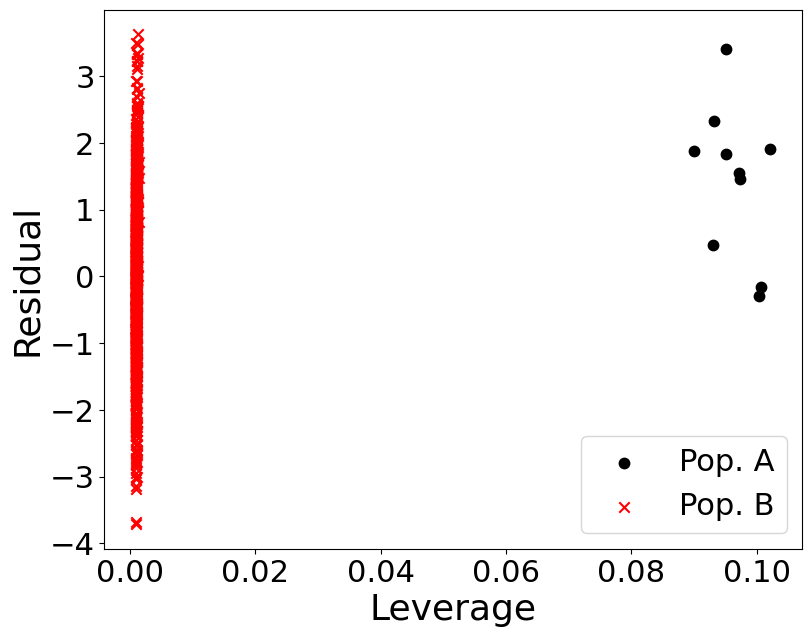

In [ ]:
# Residuals vs. Leverages
plt.figure(figsize=(9, 7))

plt.scatter(simpsons_paradox_df['leverage'][:10], simpsons_paradox_df['residual'][:10], marker='o', color='black', label='Pop. A', s=56)
plt.scatter(simpsons_paradox_df['leverage'][10:], simpsons_paradox_df['residual'][10:], marker='x', color='r', label='Pop. B', s=56)

plt.xlabel('Leverage', fontsize=26) 
plt.ylabel('Residual', fontsize=26)

plt.xticks(fontsize=22) 
plt.yticks(fontsize=22)

plt.legend(fontsize=22)
# plt.savefig('simpsons_paradox_levresid.pdf', bbox_inches='tight')
plt.show()

### Greedy Algorithms.

In [37]:
# store the original x and y.
orig_x = x
orig_y = y

# compute scores for initial round of the greedy algorithm.
orig_df, if_inds, if_scores, newton_inds, newton_scores = postprocessing.create_orig_df(orig_x, orig_y, lr, True)

orig_inds_if = if_inds
orig_inds_newton = newton_inds
# compute influence scores.
if_scores = -lr.influence_scores()[1]
# sort indices in ascending order.
if_inds = np.argsort(if_scores)
print("inds", if_inds[:10])
newton_inds = np.argsort(newton_scores)
print("newton_inds", newton_inds[:10])

# reset greedy loop.
x = orig_x
y = orig_y

inds [  1   8   3   9   5   6   2   7 907 260]
newton_inds [  1   8   3   9   5   6   2   7 907 260]


In [38]:
# run greedy
dropped_order, exact_changes_beta, beta_estimates_greedy = algorithms.Run_Greedy(orig_x, orig_y, orig_inds_if, orig_inds_newton, lr, True, method='if')

print("dropped order: \n", dropped_order[:12])
print("exact (greedy) beta estimates: \n", beta_estimates_greedy[:12])

iteration 0
index to remove (original): 1
fitted beta1: 0.5017041334413944
iteration 1
index to remove (original): 8
fitted beta1: 0.48935079165663814
iteration 2
index to remove (original): 3
fitted beta1: 0.47503745815665105
iteration 3
index to remove (original): 9
fitted beta1: 0.45750814988620736
iteration 4
index to remove (original): 5
fitted beta1: 0.43440020181188577
iteration 5
index to remove (original): 6
fitted beta1: 0.40209505897875497
iteration 6
index to remove (original): 2
fitted beta1: 0.3516815271120153
iteration 7
index to remove (original): 7
fitted beta1: 0.27973153851049654
iteration 8
index to remove (original): 4
fitted beta1: 0.10993330286566791
iteration 9
index to remove (original): 0
fitted beta1: -0.9895109324018502
iteration 10
index to remove (original): 937
fitted beta1: -0.9973904366412818
iteration 11
index to remove (original): 398
fitted beta1: -1.0051502147782017
iteration 12
index to remove (original): 735
fitted beta1: -1.0126832670557953
itera

In [39]:
greedy_inds = dropped_order[:10]
greedy_inds = np.array(greedy_inds)
type(greedy_inds)

numpy.ndarray

In [40]:
greedy_inds

array([1, 8, 3, 9, 5, 6, 2, 7, 4, 0])

In [41]:
greedy_inds
new_x= np.delete(orig_x, greedy_inds, axis=0)
new_y= np.delete(orig_y, greedy_inds, axis=0)
print(new_x.shape)
print(new_y.shape)

(1000, 2)
(1000,)


In [45]:
# Refit after removing the points specified by NetApprox (these indices are the same).
lr = LinearRegression(x=orig_x.T, y=orig_y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We will examine the first coefficient.

modified_lr = LinearRegression(x=new_x.T, y=new_y)
modified_lr.fit()
print(
    f"Estimated beta1 after removing subset: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556264
Estimated beta1 after removing subset: -0.9895109324018502
